# Pytometry analysis of mouse ICI/TRT samples from WT and Ly6g-depleted mice

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.0
sinfo       0.3.4
-----
Cython              0.29.23
PIL                 9.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
cairo               1.19.1
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
click               8.1.3
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cy

In [3]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

# Define a nice colour map for gene expression
colors2 = pl.cm.Reds(np.linspace(0, 1, 80))
colors3 = pl.cm.Greys_r(np.linspace(0.7, 0.8, 35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list("my_colormap", colorsComb)

import os

data_path = "/Volumes/hqdinh2/Projects/HNC_SPORE/Mouse_Neutrophil_ICITRT/Round1/AEG_Ultracomp_gating_Panel2/"


# Read data

In [4]:
files_all = os.listdir(data_path)
files = [fileID for fileID in files_all if fileID.endswith(".fcs")]
files 

adatas = []
for fileID in files:
    meta_info = fileID.split(".fcs")[0].split("_")
    adata = pm.io.read_fcs(data_path + fileID)
    adata.obs["sample"] = meta_info[1]

    # move Time etc to .obs
    #pm.pp.split_signal(adata, var_key="channel", option="element", data_type="facs")
    adatas.append(adata)

adatas[0].var_names

# Concatenate all data.
adata_all = ann.AnnData.concatenate(*adatas, join="outer", uns_merge="unique")

# Remove unused channels. According to Supplementary Table S5 of Oetjen et al, less channels were used than reported in the file. In addition, we add the corresponding antibody marker for each element.
marker_list = adata_all.var["marker"].values

rename_dict = {}
for marker in marker_list:
    elem_info = marker.split("-")
    rename_dict[marker] = elem_info[-1] if len(elem_info) > 1 else "unused"
    if elem_info[-1] == "DR":  # fix HLR-DR
        rename_dict[marker] = "-".join(elem_info[-2:])

adata_all.var["AB"] = pd.Categorical(adata_all.var["marker"]).map(rename_dict)

# Remove the unused channels, i.e. the ones with no marker or the ones termed ‘Environ’ or ‘EQ4beads’.
marker_keep = [
    marker
    for marker in adata_all.var["AB"]
    if marker not in ["unused", "Environ", "beads"]
]

adata_all = adata_all[:, np.in1d(adata_all.var["AB"], marker_keep)]
adata_all

#View of AnnData object with n_obs × n_vars = 4938816 × 37
    #obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch'
    #var: 'channel', 'marker', 'signal_type', 'AB'
    #uns: 'meta'

#Save to file.
adata_all.write(data_path + "facs_data_concatenated.h5ad")

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.var` of view, copying.
... storing '$PnG' as categorical
/opt/an

... storing '$PnR-6' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.var` of view, copying.
... storing '$PnR-7' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.var` of view, copying.
... storing '$PnR-8' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pa

KeyboardInterrupt: 

In [41]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('meta', {'__header__': {'FCS format': 'FCS3.1', 'text start': 58, 'text end': 5771, 'data start': 5772, 'data end': 22942831, 'analysis start': 0, 'analysis end': 0}, 'fil': 'export_A5_Live CD45+.fcs', 'tot': 133355, 'par': 43, 'byteord': '1,2,3,4', 'datatype': 'F', 'fj_fcs_version': '3.1', 'mode': 'L', 'cyt': '4486521 Attune NxT Acoustic Focusing Cytometer (Lasers: BRVY)', 'sys': 'XE2-IOT-2019 Microsoft Windows 10 Enterprise LTSC', 'btim': '11:17:57', 'cells': 'NA', 'com': 'NA', 'cytsn': '2AFC227901019', 'date': '11-Aug-2022', 'etim': '11:18:42', 'exp': 'NA', 'inst': 'NA', 'originality': 'Original', 'lost': '0', 'op': 'PI Morris', 'smno': 'Group', 'src': 'NA', 'timestep': '0.001', 'vol': '150000', 'wellid': 'A5', '#coincidentcount': '547369', '#flowrate': '200', '#LASER1ASF': '1.10', '#LASER1COLOR': 'Blue', '#LASER1DELAY': '1100', '#LASER2ASF': '1.14', '#LASER2COLOR': 'Red', '#LASER2DELAY': '1495', '#LASER3ASF': '1.14', '#LASER3COLOR': 'Violet'

# Pre-process data

In [42]:
adata_all = sc.read(data_path + "facs_data_concatenated.h5ad")
adata_all

adata_all.obs["sample"].value_counts()

G4    222173
E4    218041
H4    211351
F5    187591
C5    181042
F4    155207
B5    151920
B4    136561
E5    133747
A5    133355
D4    128482
D5    126878
H5    121103
A6    118264
D6    117808
C4    110950
C6    103646
G5     92392
B6     90483
A4     84828
Name: sample, dtype: int64

## Normalize data

In [53]:
# We use a normalization cofactor of 5.
cofactor = 5

# Save original data as layer.
adata_all.layers["original"] = adata_all.X

# Normalize.
pm.tl.normalize_arcsinh(adata=adata_all, cofactor=cofactor)

adata_all.write(data_path + "facs_data_norm.h5ad")

# Visualize the data with a UMAP

### Assessing appropriate # of PCs

computing PCA
    with n_comps=41
    finished (0:00:12)


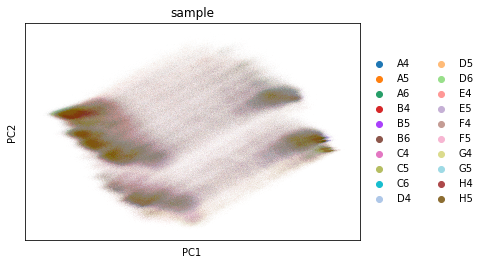

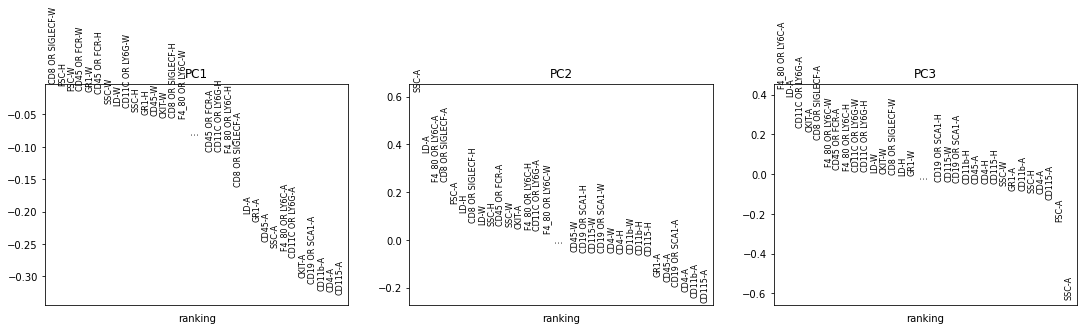

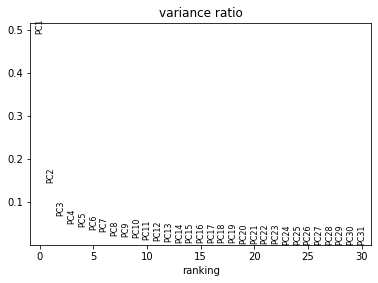

In [54]:
adata_all = sc.read(data_path + "facs_data_norm.h5ad")

#In the next step, we compute a knn-graph, an embedding and a clustering of the data.
sc.pp.pca(adata_all)
sc.pl.pca_overview(adata_all, color="sample")

In [55]:
sc.pp.pca(adata_all, n_comps=10)
sc.pp.neighbors(adata_all, n_neighbors=15, use_rep="X_pca")

computing PCA
    with n_comps=10
    finished (0:00:04)
computing neighbors


/opt/anaconda3/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:45)


In [56]:
adata_all
adata_all.write(data_path + "facs_data_norm.h5ad")

AnnData object with n_obs × n_vars = 2825822 × 42
    obs: 'sample', 'batch'
    var: 'Channel Number', '$PnB', 'channel', 'marker', '$PnG', '$PnE', '$PnR-0', '$PnR-1', '$PnR-10', '$PnR-11', '$PnR-12', '$PnR-13', '$PnR-14', '$PnR-15', '$PnR-16', '$PnR-17', '$PnR-18', '$PnR-19', '$PnR-2', '$PnR-3', '$PnR-4', '$PnR-5', '$PnR-6', '$PnR-7', '$PnR-8', '$PnR-9', 'AB'
    uns: 'meta', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'original'
    obsp: 'connectivities', 'distances'

In [5]:
adata_all = sc.read(data_path + "facs_data_norm.h5ad")
adata_all

AnnData object with n_obs × n_vars = 2825822 × 42
    obs: 'sample', 'batch'
    var: 'Channel Number', '$PnB', 'channel', 'marker', '$PnG', '$PnE', '$PnR-0', '$PnR-1', '$PnR-10', '$PnR-11', '$PnR-12', '$PnR-13', '$PnR-14', '$PnR-15', '$PnR-16', '$PnR-17', '$PnR-18', '$PnR-19', '$PnR-2', '$PnR-3', '$PnR-4', '$PnR-5', '$PnR-6', '$PnR-7', '$PnR-8', '$PnR-9', 'AB'
    uns: 'meta', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'original'
    obsp: 'connectivities', 'distances'

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:54:25)


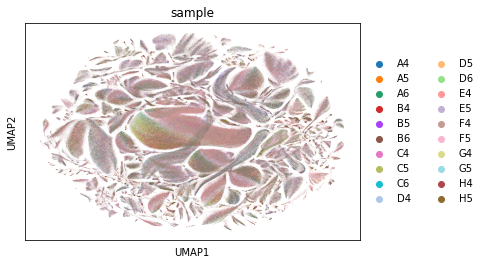

In [6]:
sc.tl.umap(adata_all)

sc.pl.umap(adata_all, color="sample")

In [14]:
adata_all.write(data_path + "facs_data_norm.h5ad")
#sc.tl.leiden(adata_all, resolution = 0.2, key_added='leiden_0.2')